### 참고
* https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html 
    * 텐서보드 튜토리얼
* https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html
    * 파이토치 빠른 시작
* https://tutorials.pytorch.kr/recipes/recipes/saving_and_loading_a_general_checkpoint.html
    * 체크포인트 저장
* https://tutorials.pytorch.kr/beginner/saving_loading_models.html
    * 모델 저장하기, 불러오기

In [6]:
import argparse
import yaml
import torch

from torch.utils.tensorboard import SummaryWriter
from torch import nn

from utils.dataset import *
from utils.encoder import *
from nnet.CRNN import *
from utils.util import *

# from nnet.CRNN import CRNN

### 1. Argument 설정

In [7]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "-d", "--data", 
    default="MIVIA", 
    action="store",
    help="The dataset using training")

parser.add_argument(
    "-c", "--conf_file",
    default="./config/default.yaml", 
    help="The configuration file with all the experiment parameters.",
    )

parser.add_argument(
    "-m", "--mode",
    default="train", 
    help="train or test",
    )

parser.add_argument(
    "--gpu",
    default="0",
    type = int,
    help="The number of GPUs to train on, or the gpu to use, default='0', "
    "so uses one GPU",
)

parser.add_argument(
    "--test_from_checkpoint", default=None, help="Test the model specified"
)

# args = parser.parse_args()
args = parser.parse_args(["--data", "MIVIA", "--conf_file", "./config/default.yml", "-m" "train"])


In [8]:
with open(args.conf_file, "r") as f:
    conf = yaml.safe_load(f)

### 2. data configuration

In [9]:
encoder = multi_label_encoder(
    fs = conf['feats']['sample_rate'], 
    audio_len = conf['feats']['audio_len'], 
    n_fft = conf['feats']['n_fft'], 
    hop_length = conf['feats']['hop_length'], 
    net_pooling = conf['feats']['net_pooling']
    )

training_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_traindata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

test_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_testdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

validation_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_valdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )
# test_data = mivia(conf['data']['audio_folder'], conf['data']['xml_folder'], encoder, partition = conf['data']['select_testdata'], transform = MelSpectrogram_transform(conf['feats']))

In [10]:
print(MelSpectrogram_transform(conf['feats']))

MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)


### 3. device, hyperparameter, tensorboard configuration 

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# train, validation configuration
learning_rate = conf['opt']['lr'] # 1e-3
batch_size = conf['training']['batch_size']
epochs = conf['training']['n_epochs']
ckpt_dir = conf['training']['ckpt_path']
log_dir = conf['training']['log_path']

# save path(model) make
ckpt_dir = os.path.join(ckpt_dir, args.data + time.strftime('_%Y_%m_%d_%I_%M',time.localtime(time.time()))) # './checkpoint\\MIVIA_2022_07_26_11_26'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# log path(tensorboard) make
if args.test_from_checkpoint is not None: # test tensorboard directory configuration
    log_dir = os.path.join(log_dir, os.path.basename(ckpt_dir), args.mode) # tensorboard directory
else: # training / validation tensorboard directory
    log_dir = os.path.join(log_dir, args.data + time.strftime('_%Y_%m_%d_%I_%M',time.localtime(time.time())), args.mode) # ./runs\MIVIA_2022_07_26_11_46\train

writer = SummaryWriter(log_dir = log_dir)

In [12]:
print(ckpt_dir)

./checkpoint\MIVIA_2022_07_28_04_31


In [13]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)       # C, D
validation_dataloader = DataLoader(validation_data, batch_size, shuffle = True) # B
test_dataloader = DataLoader(test_data, 1, shuffle = False)             # A

In [14]:
print(len(train_dataloader))
print(len(train_dataloader.dataset))
print(len(validation_dataloader)) # batch size 수
print(len(validation_dataloader.dataset)) # 전체 sample 갯수
print(len(test_dataloader))
print(len(test_dataloader.dataset))

15
29
7
14
14
14


### 4. model, loss function, optimizer 정의

In [15]:
model = CRNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. train 정의

In [16]:
########################################################################################################################
#                                                         Train                                                        #
########################################################################################################################
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)  # 전체 training data의 size
    num_batches = len(dataloader)   # number of batch

    ## 테스트 더 할라면 여기다가 load 추가, if문이 좋음.

    model.train()

    running_loss = 0.0
    
    for batch_idx, (X, y) in enumerate(dataloader, 0): 
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X[:,:,:3750]) # [batch, frame, class]
        loss = loss_fn(pred, y)  

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 기록
        running_loss += loss.item()

        print("Train : EPOCH %04d / %04d  | BATCH %04d | LOSS %.4f" %
              (epoch, conf['training']['n_epochs'], batch_idx, running_loss/(batch_idx+1)))

    running_loss = running_loss/num_batches #

    return running_loss



### 6. Validation
* 4가지 임시로 추가함

In [17]:
# 임시로 추가
def F1_score(mod, TF, t_test):

        TP = ((mod*TF) != 0).sum()
        TN = (( (torch.logical_not(mod.type(torch.bool)))*TF) != 0).sum()
        FP = ((mod*(torch.logical_not(TF.type(torch.bool)))) != 0).sum()
        FN = (((torch.logical_not(mod.type(torch.bool)))*(torch.logical_not(TF.type(torch.bool)))) != 0).sum()
        
        # G_noCC = torch.logical_not(mod[:,0].type(torch.bool))
        # G_noTS = torch.logical_not(mod[:,1].type(torch.bool))
        # T11 = ((mod[:,0]*t_test[:,0]) != 0).sum()
        # T12 = (((mod[:,1]*G_noCC)*t_test[:,0]) != 0).sum()
        # T13 = (((G_noCC*G_noTS)*t_test[:,0]) != 0 ).sum()
        # T21 = (((mod[:,0]*G_noTS)*t_test[:,1]) != 0).sum()
        # T22 = ((mod[:,1]*t_test[:,1]) != 0).sum()
        # T23 = (((G_noCC*G_noTS)*t_test[:,1]) != 0).sum()
        # T = [[T11,T12,T13],[T21,T22,T23]]

        P = torch.true_divide(TP,TP+FP + 0.00001)
        R = torch.true_divide(TP,TP+FN + 0.00001)
        F1 = torch.true_divide(2*P*R , P+R + 0.00001).item()
        # ER = torch.true_divide(FP+FN,TP+FN).item()
        # FPR = torch.true_divide(FP, FP+TN).item()
        # #pdb.set_trace()
        # acc = torch.true_divide(TP+TN , FP+FN+TP+TN).item()
        
        # Total = sum(sum(T, []))
        # RecRate = (T[0][0]+T[1][1]).item()/ Total.item()
        # MissRate = (T[0][2] + T[1][2]).item()/Total.item()
        # ErrorRate = (T[0][1] + T[1][0]).item()/Total.item()

        return F1

In [18]:
########################################################################################################################
#                                                      VALIDATION                                                      #
########################################################################################################################

def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    validation_loss, correct = 0, 0

    score = 0.0 #임시로 추가 1

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X[:,:,:3750])
            validation_loss += loss_fn(pred, y).item()
            correct = 0
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            ### 임시로 추가 2

            mod_binary = torch.ge(pred, 0.4)
            label_binary = torch.ge(y, 0.4)
            is_correct = torch.eq(mod_binary, label_binary)

            score += F1_score(mod_binary,is_correct,y)

            ### 임시로 추가 

    validation_loss /= num_batches
    correct /= size

    score /= num_batches # 임시로 추가 3

    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f}, f1: {score} \n")

    return validation_loss


    # # 임시로 추가 4
    # writer.add_scalar('f1', score, epoch)
    # #임시로 추가

    # print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f}, f1: {score} \n")

### 7. train & validation 실행

In [19]:
best_loss = 1000

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, epoch = t+1)
    validation_loss = validation(validation_dataloader, model, loss_fn)

    # tensor board
    writer.add_scalar('training loss', train_loss, t+1)
    writer.add_scalar('validation loss', validation_loss, t+1)

    # model save
    save(EPOCH = t+1, net = model, optimizer = optimizer, TRAIN_LOSS = train_loss, VAL_LOSS = validation_loss, PATH = ckpt_dir)
    if validation_loss < best_loss:

        best_loss = validation_loss
        save_best_model(EPOCH = t+1, net = model, optimizer = optimizer, TRAIN_LOSS = train_loss, VAL_LOSS = validation_loss, PATH = ckpt_dir)
        print(f"--------------------------------------------")
        
print("Done!")

Epoch 1
-------------------------------
Train : EPOCH 0001 / 0300  | BATCH 0000 | LOSS 0.7324


KeyboardInterrupt: 

### 8. test

In [105]:
with open(args.conf_file, "r") as f:
    conf = yaml.safe_load(f)

In [21]:
conf['test']['ckpt_path']

'./checkpoint/MIVIA_2022_07_27_08_15'

In [22]:


def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  # plt.show(block=False)

  fig.canvas.draw()
  plot = fig2np(fig)
  return plot

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

### This function(play_audio) operates only on jupyter notebook.(not vscode)
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


def fig2np(fig):
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data










In [106]:
########################################################################################################################
#                                                         TEST                                                         #
########################################################################################################################

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    ### 로드 추가(only model)
    model, _, _, _, _ = load_bestmodel(PATH = conf['test']['ckpt_path'], model = model, optimizer = optimizer, device = torch.device('cuda')) # best model

    model.eval()
    test_loss, correct = 0, 0

    score = 0.0 #임시로 추가 1

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device) # X : [batchsize, frequency, frame]
            pred = model(X[:,:,:3750]) #[batchsize, frame, class]
            test_loss += loss_fn(pred, y).item()

            # input feature visualization torch.ge(pred, 0.5)

            mod_binary = torch.ge(pred, 0.4)

            ### 임시로 추가 2
            mod_binary = torch.ge(pred, 0.4)
            label_binary = torch.ge(y, 0.4)
            is_correct = torch.eq(mod_binary, label_binary)
            score += F1_score(mod_binary,is_correct,y)
            ### 임시로 추가 

            
            
            
            

            writer.add_image(f'spectrogram{i}', plot_spectrogram(X.cpu().squeeze(), title = f'{i}'))
            writer.add_image(f'label{i}', matplotlib_label_show(y.cpu().squeeze(), title = f'label {i}'))
            writer.add_image(f'prediction{i}', matplotlib_label_show(pred.detach().cpu().squeeze(), title = f'prediction {i}'))
            writer.add_image(f'post{i}', matplotlib_label_show(mod_binary.detach().cpu().squeeze(), title = f'post {i}'))

            correct = 0
            # correct += (pred.argmax(1) == /y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    score /= num_batches # 임시로 추가 3


    # ...학습 중 손실(running loss)을 기록하고
    writer.add_scalar('test loss', test_loss)
    print(f"test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, f1 : {score} \n")

    return test_loss

c:\anaconda3\envs\SED\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


TypeError: Cannot handle this data type: (1, 1, 288), |u1

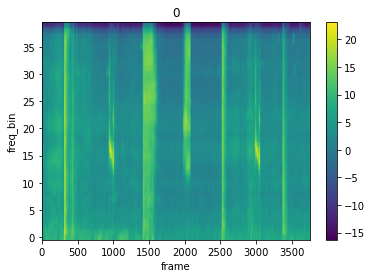

In [107]:
test_loss = test(test_dataloader, model, loss_fn)
print(test_loss)

### test 결과 시각화

In [115]:
import scipy

def matplotlib_label_show(target):
    n_frame = target.shape[0] # target.shape[0] = segment

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.arange(n_frame)  #(60,)
    y1 = target[:,0]        #(60,) 
    y2 = target[:,1]        #(60,) tire skidding
    y3 = target[:,2]        #(60,) car crash

    ax1.plot(x, y1, label = 'scream')
    ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
    ax1.plot(x, y3, label = 'car crash', color = 'green')


    ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
    # ax1.set_title('{}'.format(xmlfile))


    plt.show()


def median_filter(pred, median_window, thresholds):
    # pred : [batch, frame, class]
    pred = pred.squeeze() # [frame, class]
    post_filter = scipy.ndimage.filters.median_filter(pred.cpu().detach().numpy(), (median_window, 1)) # [frames, class]
    post_filter = (post_filter>thresholds).astype(float)
    
    return torch.Tensor(post_filter).unsqueeze(0)

In [236]:
spectrogram, label = next(iter(test_dataloader))

In [317]:
for i, (x, y) in enumerate(test_dataloader):
    if i == 3: 
        spectrogram = x
        label = y


        break

In [318]:
label = label.to(device)
spectrogram = spectrogram.to(device)

In [319]:
model = CRNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [320]:
model, _, _, _, _ = load_bestmodel(PATH = conf['test']['ckpt_path'], model = model, optimizer = optimizer, device = torch.device('cuda')) # best model
print(conf['test']['ckpt_path'])

./checkpoint/MIVIA_2022_07_27_08_15


In [321]:
print(label.dtype)
print(conf['test']['threshold'])

torch.float32
0.5


In [322]:
pred = model(spectrogram[:,:,:3750])

post = torch.ge(pred, 0.5)
post_filter = median_filter(pred, conf['test']['median_window'], conf['test']['threshold'])

In [323]:
print(pred.type, pred.device)
print(post.type, post.device)
print(post_filter.type, post_filter.device)

<built-in method type of Tensor object at 0x0000022F3CA33138> cuda:0
<built-in method type of Tensor object at 0x0000022F2E072DB8> cuda:0
<built-in method type of Tensor object at 0x0000022F2BE92458> cpu


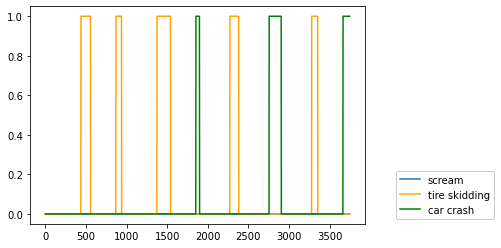

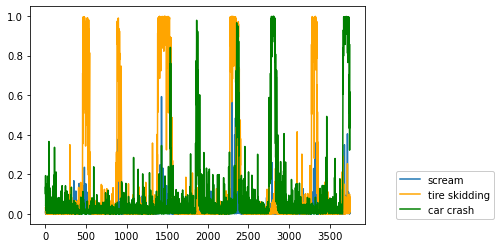

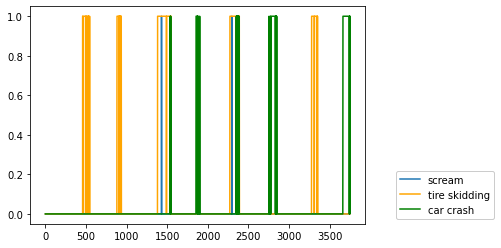

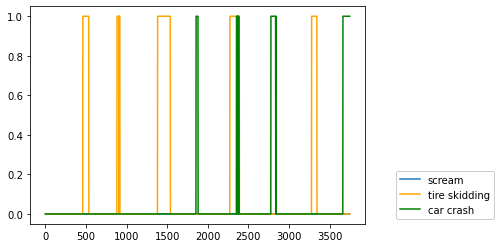

In [324]:
matplotlib_label_show(label.cpu().squeeze())
matplotlib_label_show(pred.detach().cpu().squeeze())
matplotlib_label_show(post.detach().cpu().squeeze())
matplotlib_label_show(post_filter)


torch.Size([3750, 3])


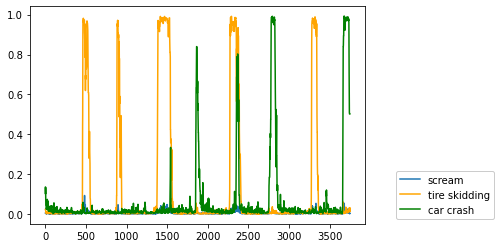

In [326]:
post_filter = pred.squeeze() # [frame, class]
print(post_filter.shape)

post_filter = scipy.ndimage.filters.median_filter(post_filter.cpu().detach().numpy(), (7, 1)) # [frames, n_class]

matplotlib_label_show(post_filter)

In [331]:
post_filter = (post_filter>0.5).astype(float)
post_filter = torch.Tensor(post_filter)

print(post_filter.shape, post_filter.dtype)

torch.Size([3750, 3]) torch.float32


In [334]:

print(post_filter.unsqueeze(0).shape)

torch.Size([1, 3750, 3])


data 1


c:\anaconda3\envs\SED\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


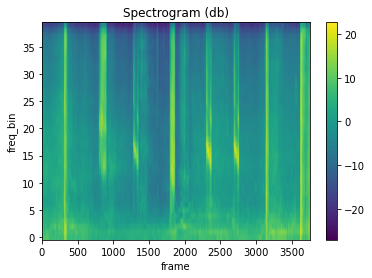

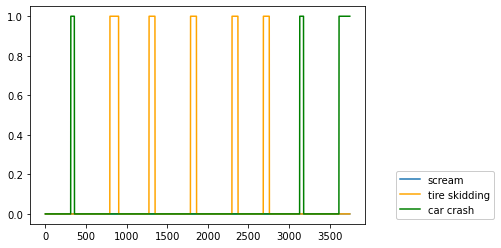

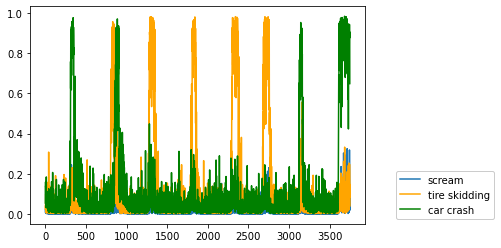

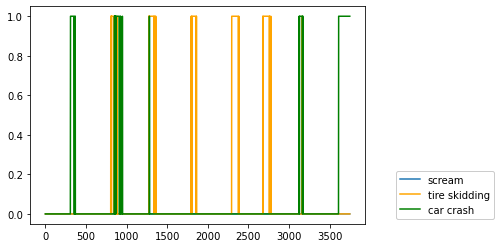

In [212]:
print("data 1")
plot_spectrogram(spectrogram.cpu().squeeze())
matplotlib_label_show(label.cpu().squeeze())
matplotlib_label_show(pred.detach().cpu().squeeze())
matplotlib_label_show(torch.ge(pred, 0.4).detach().cpu().squeeze())

# plot_spectrogram(spectrogram.cpu()[1])
# matplotlib_label_show(label.cpu()[1])
# matplotlib_label_show(pred.detach().cpu())

In [74]:
a = np.array([0.1, 0.2, 0.3, 0.5, 0.6, 0.7])
print(a)
print(type(a))

[0.1 0.2 0.3 0.5 0.6 0.7]
<class 'numpy.ndarray'>


In [75]:
print(a > 0.5)
print(type((a>0.5)))

[False False False False  True  True]
<class 'numpy.ndarray'>


In [76]:
(a>0.5).dtype

dtype('bool')

In [79]:
b = (a>0.5).astype(float)

In [80]:
print(b)

[0. 0. 0. 0. 1. 1.]


In [81]:
c = torch.Tensor(b)

In [82]:
print(c)

tensor([0., 0., 0., 0., 1., 1.])


In [ ]:
def median_filter(pred, median_window, thresholds):
    # pred : [batch, frame, class]
    pred = pred.squeeze() # [frame, class]
    post_filter = scipy.ndimage.filters.median_filter(post_filter.cpu().detach().numpy(), (median_window, 1)) # [frames, class]
    post_filter = (post_filter>thresholds).astype(float)
    
    return torch.Tensor(post_filter).unsqueeze(0)